## Data Loading and Cleaning

In this section, we load the Online Retail dataset and perform initial data cleaning to ensure data quality for further analysis.

**Steps performed:**
- Imported the necessary libraries (`pandas` and `numpy`).
- Loaded the dataset from the CSV file using the appropriate encoding.
- Displayed the first few rows and a summary of the dataset structure.
- Removed duplicate rows to avoid repeated records.
- Filtered out records with non-positive (`<=0`) `Quantity` or `UnitPrice`, ensuring only valid transactions are kept.
- Removed rows with missing `CustomerID` values, as customer-level analyses require this field.
- Converted the `InvoiceDate` column to proper datetime format for easier time-based analysis.

**Result:**  
After cleaning, the dataset contains **541,909** transactions with the following main fields:
- Invoice number
- Product code and description
- Quantity and unit price
- Customer ID
- Country
- Date and time of purchase

This cleaned data provides a reliable foundation for subsequent analyses such as sales trend visualization, customer segmentation, and market basket analysis.


In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

print(df.head())
print(df.info())

# 清洗
df = df.drop_duplicates()
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df.dropna(subset=['CustomerID'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

## Exploratory Data Analysis: Overview and Sales Trend

This section provides an overview of the cleaned dataset and explores key characteristics through descriptive statistics and visualizations.

**Key steps and findings:**

- **Product Variety:** There are **3,665** unique products in the dataset.
- **Customer Base:** There are **4,338** unique customers.
- **Top Countries:** The top countries by transaction count are the United Kingdom (349,203), Germany (9,025), France (8,326), EIRE (Ireland, 7,226), and Spain (2,479).
- **Date Range:** The data covers transactions from **December 1, 2010** to **December 9, 2011**.

- **Monthly Sales Visualization:**  
  Monthly total sales (in monetary value) were calculated and plotted to reveal sales trends over the year. The resulting line chart shows overall growth in sales, with notable increases in the latter months of 2011, suggesting potential seasonality or business growth during that period.

This exploratory analysis establishes a solid understanding of the dataset’s scope, customer and product diversity, and temporal sales patterns.


Unique products: 3665
Unique customers: 4338
Country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Name: count, dtype: int64
Date range: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


<Axes: title={'center': 'Monthly Sales'}, xlabel='Month'>

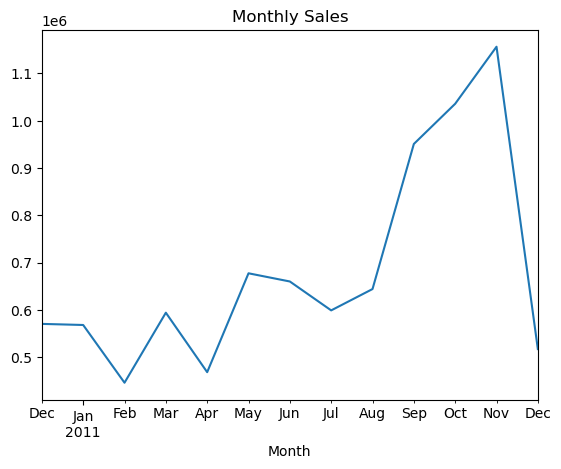

In [ ]:
# Type of products
print("Unique products:", df['StockCode'].nunique())

# Number of customers
print("Unique customers:", df['CustomerID'].nunique())

# Distribution of country
print(df['Country'].value_counts().head())

# Time ranges
print("Date range:", df['InvoiceDate'].min(), "-", df['InvoiceDate'].max())

# Monthly sale.
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(title='Monthly Sales')


## RFM Customer Value Segmentation

In this section, we conduct an RFM (Recency, Frequency, Monetary) analysis to evaluate customer value and segment the customer base.

**Approach:**
- **Recency (R):** Number of days since each customer's last purchase, relative to the most recent transaction in the dataset.
- **Frequency (F):** Total number of transactions made by each customer.
- **Monetary (M):** Total monetary value of purchases made by each customer.

Each RFM metric is divided into 4 categories (quartiles), with higher values representing better customer characteristics (e.g., more recent, more frequent, higher spending).  
A combined **RFM Score** is then created by concatenating the R, F, and M categories for each customer.

**Sample Output:**  
The resulting table shows each customer’s recency, frequency, and monetary values, their corresponding quartile groups, and the composite RFM score. This segmentation lays the foundation for targeted marketing, loyalty analysis, and customer relationship strategies.


In [ ]:
import datetime

# Most recent date.
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# RFM Classification
rfm['R'] = pd.cut(rfm['Recency'], bins=4, labels=[4,3,2,1])
rfm['F'] = pd.cut(rfm['Frequency'], bins=4, labels=[1,2,3,4])
rfm['M'] = pd.cut(rfm['Monetary'], bins=4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

print(rfm.head())


            Recency  Frequency  Monetary  R  F  M RFM_Score
CustomerID                                                 
12346.0         326          1  77183.60  1  1  2       112
12347.0           2          7   4310.00  4  1  1       411
12348.0          75          4   1797.24  4  1  1       411
12349.0          19          1   1757.55  4  1  1       411
12350.0         310          1    334.40  1  1  1       111


## Customer Segmentation Using KMeans Clustering

In this section, we apply KMeans clustering to the RFM metrics to segment customers into distinct behavioral groups.

**Approach:**
- Standardized the RFM features (`Recency`, `Frequency`, `Monetary`) for fair clustering.
- Used the KMeans algorithm to group customers into 4 clusters based on their purchasing behaviors.
- Calculated the average RFM values for each cluster to interpret customer characteristics.

**Cluster Profiles:**
- Each cluster represents a different type of customer:
    - **Low Recency, High Frequency & Monetary**: Loyal and high-value customers.
    - **High Recency, Low Frequency & Monetary**: Inactive or low-value customers.
    - Other clusters show various combinations of recency, frequency, and spending patterns.

This segmentation helps identify key customer groups for targeted marketing, retention strategies, and business insights.


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())


            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1353.625312
1        248.075914   1.552015     478.848773
2          7.384615  82.538462  127187.959231
3         15.500000  22.333333   12690.500392


## Market Basket Analysis

This section applies market basket analysis (association rule mining) to uncover product combinations that are frequently purchased together.

**Approach:**
- Selected transactions from the United Kingdom and considered only positive sales (excluding returns).
- Transformed the transaction data into a basket format where each row represents an invoice and each column represents a product; entries indicate whether a product was purchased (1) or not (0) in a given transaction.
- Used the Apriori algorithm to identify frequent itemsets with a minimum support of 2%.
- Generated association rules to reveal strong relationships between products, evaluating metrics such as support, confidence, and lift.

**Key Findings:**  
The table shows the top product associations, indicating which items are likely to be purchased together. For example, customers who buy an "ALARM CLOCK BAKELIKE GREEN" are also highly likely to buy an "ALARM CLOCK BAKELIKE RED", as evidenced by high confidence and lift values.

These insights can be used for cross-selling strategies, product placement, and personalized recommendations.


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Choose UK, Only choose quantity >0 (no return)
basket = df[(df['Country'] == 'United Kingdom') & (df['Quantity'] > 0)]
basket = basket.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apriori Algrithm finds most bought products.
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


/var/folders/bt/159y_h211qb_80xw9cxg53rw0000gn/T/ipykernel_52986/2702101231.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
/Applications/anaconda3/lib/python3.13/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                            antecedents                           consequents  \
0          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED )   
1           (ALARM CLOCK BAKELIKE RED )          (ALARM CLOCK BAKELIKE GREEN)   
2  (GARDENERS KNEELING PAD CUP OF TEA )   (GARDENERS KNEELING PAD KEEP CALM )   
3   (GARDENERS KNEELING PAD KEEP CALM )  (GARDENERS KNEELING PAD CUP OF TEA )   
4      (PINK REGENCY TEACUP AND SAUCER)     (GREEN REGENCY TEACUP AND SAUCER)   

    support  confidence       lift  
0  0.027274    0.657971  14.449321  
1  0.027274    0.598945  14.449321  
2  0.027514    0.730463  16.387169  
3  0.027514    0.617251  16.387169  
4  0.024270    0.819473  22.289120  


## Sales Trend and Customer Segmentation Visualization

This section presents two key analyses: the overall sales trend across months, and the distribution of customer segments in the business.

---

### 1. Monthly Quantity Sold

- **What was done:**  
  The total number of items sold each month was aggregated and visualized in a line chart.
- **What does the result show?**  
  The plot shows a clear upward trend in monthly sales through most of the year, with especially rapid growth in the second half. The peak in November suggests a strong seasonality effect, likely due to holiday shopping or end-of-year promotions. The sharp drop in December may be due to incomplete data for that month.  
  **Business interpretation:** The company experienced significant sales growth over time, with critical sales periods in late Q3 and Q4. This insight can guide planning for inventory, staffing, and marketing campaigns.

---

### 2. Customer Segmentation (PCA Visualization)

- **What was done:**  
  Customers were clustered into four segments based on RFM values, and a PCA scatter plot shows the distribution of these segments in two-dimensional space.
- **What does the result show?**  
  In the PCA plot, different colors represent different customer clusters:
  - There are clear separations between clusters, indicating that customer purchasing behaviors are meaningfully different between groups.
  - One cluster (e.g., the yellow points) is widely spread out and located far from the others—these are likely your highest frequency and monetary value customers, as confirmed by the earlier cluster means.
  - Another cluster (e.g., the dense cluster near the origin) likely represents low-frequency, low-value, or recently inactive customers.
  - The distribution suggests that the business has a small group of very high-value customers and a much larger group of less active buyers.
  **Business interpretation:** This segmentation helps the company identify which customers contribute most to revenue and which are at risk of churning, supporting more targeted retention or loyalty strategies.

---

**Summary:**  
- The business saw strong overall sales growth, with seasonal effects driving major peaks.
- Customer behavior is highly heterogeneous: a small segment of customers are exceptionally valuable, while most are less frequent buyers.
- These insights support focused marketing and resource allocation, ensuring high-value customers receive special attention.


<Axes: title={'center': 'Monthly Quantity Sold'}, xlabel='Month'>

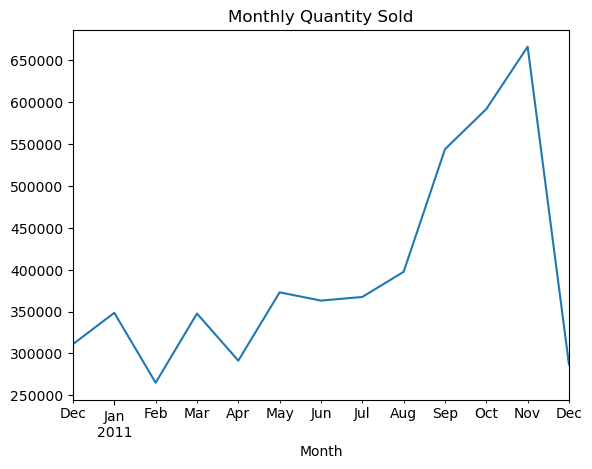

In [ ]:
# trend of sale.
sales_trend = df.groupby('Month')['Quantity'].sum()
sales_trend.plot(title='Monthly Quantity Sold')



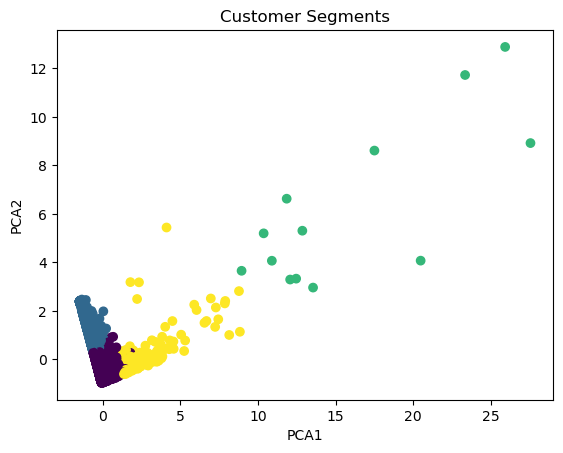

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['Cluster'])
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Customer Segments')
plt.show()
